# Proyecto final
### Machine Learning
#### Integrantes: Alejandra Ospina (00212243)
#### Fecha: 2023-05-10


### Introducción
*Aqui se inserta la introducción*

##### Import de libraries

In [13]:
# Import libraries  
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from tabulate import tabulate
from sklearn.manifold import TSNE
import string
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from keras.models import Model
from keras.datasets import imdb

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input,Embedding,Dense,Flatten
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import f1_score

from sklearn.model_selection import RepeatedStratifiedKFold

import warnings
warnings.filterwarnings('ignore')

##### Import dataset

In [3]:
#Import dataset 
dataset = pd.read_csv('Tweets.csv', encoding='latin-1')
dataset.columns = ['ID','text', 'selected_text', 'sentiment']

# Get columns selected_text and sentiment
selected_text = np.array(dataset['selected_text'].astype(str))
sentiments = np.array(dataset['sentiment'])

#Data visualization 
headers = ['Selected Text (Tweets)', 'Target (Sentiment)']
complete_table = np.column_stack([selected_text, sentiments]) 
table = tabulate(complete_table[0:10,:], headers, tablefmt="rst")
print ("Visualizing first 20 rows")
print(table)

Visualizing first 20 rows
============================================================================================  ====================
Selected Text (Tweets)                                                                        Target (Sentiment)
============================================================================================  ====================
I`d have responded, if I were going                                                           neutral
Sooo SAD                                                                                      negative
bullying me                                                                                   negative
leave me alone                                                                                negative
Sons of ****,                                                                                 negative
http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth  neutral
fun            

##### Clean text (tweets)

In [4]:
# Initialize an empty list to hold the cleaned selected text
cleaned_selected_text = []

# Define a regular expression pattern to match punctuation, symbols, and URLs
pattern = r'[^\w\s]|http\S+|www.\S+'

# Iterate through each selected text in the dataset
for text in selected_text:
    # Use regular expressions to remove punctuation, symbols, and URLs
    cleaned_text = re.sub(pattern, '', text)
    # Append the cleaned selected text to the list
    cleaned_selected_text.append(cleaned_text.lower())

# Print the first 10 cleaned selected texts
print(cleaned_selected_text[:10])

['id have responded if i were going', 'sooo sad', 'bullying me', 'leave me alone', 'sons of ', '  some shameless plugging for the best rangers forum on earth', 'fun', 'soooo high', 'both of you', 'wow u just became cooler']


##### Vectorize text

In [5]:
# Initialize an empty list to hold the tokenized tweets
tokenized_selected_text = []

# Iterate through each selected text in the dataset to tokenize each sentence
for cleaned_text in cleaned_selected_text:
    # Split the text
    tokenized_text = cleaned_text.split()
    
    # Append the tokenized selected text to the list
    tokenized_selected_text.append(tokenized_text)

tokenized_selected_text = tokenized_selected_text
print(tokenized_selected_text)

[['id', 'have', 'responded', 'if', 'i', 'were', 'going'], ['sooo', 'sad'], ['bullying', 'me'], ['leave', 'me', 'alone'], ['sons', 'of'], ['some', 'shameless', 'plugging', 'for', 'the', 'best', 'rangers', 'forum', 'on', 'earth'], ['fun'], ['soooo', 'high'], ['both', 'of', 'you'], ['wow', 'u', 'just', 'became', 'cooler'], ['as', 'much', 'as', 'i', 'love', 'to', 'be', 'hopeful', 'i', 'reckon', 'the', 'chances', 'are', 'minimal', 'p', 'im', 'never', 'gonna', 'get', 'my', 'cake', 'and', 'stuff'], ['like'], ['dangerously'], ['lost'], ['test', 'test', 'from', 'the', 'lg', 'env2'], ['uh', 'oh', 'i', 'am', 'sunburned'], ['sigh'], ['sick'], ['onna'], ['hes', 'just', 'not', 'that', 'into', 'you'], ['oh', 'marly', 'im', 'so', 'sorry', 'i', 'hope', 'you', 'find', 'her', 'soon', '3', '3'], ['interesting'], ['is', 'cleaning', 'the', 'house', 'for', 'her', 'family', 'who', 'is', 'comming', 'later', 'today'], ['gotta', 'restart', 'my', 'computer', 'i', 'thought', 'win7', 'was', 'supposed', 'to', 'put',

In [6]:
#Word2Vec (Embedding)
model_w2v = Word2Vec(sentences=tokenized_selected_text, vector_size=100, window=5)

model_w2v.train(tokenized_selected_text, total_examples= len(tokenized_selected_text), epochs=20)

(2550142, 3832200)

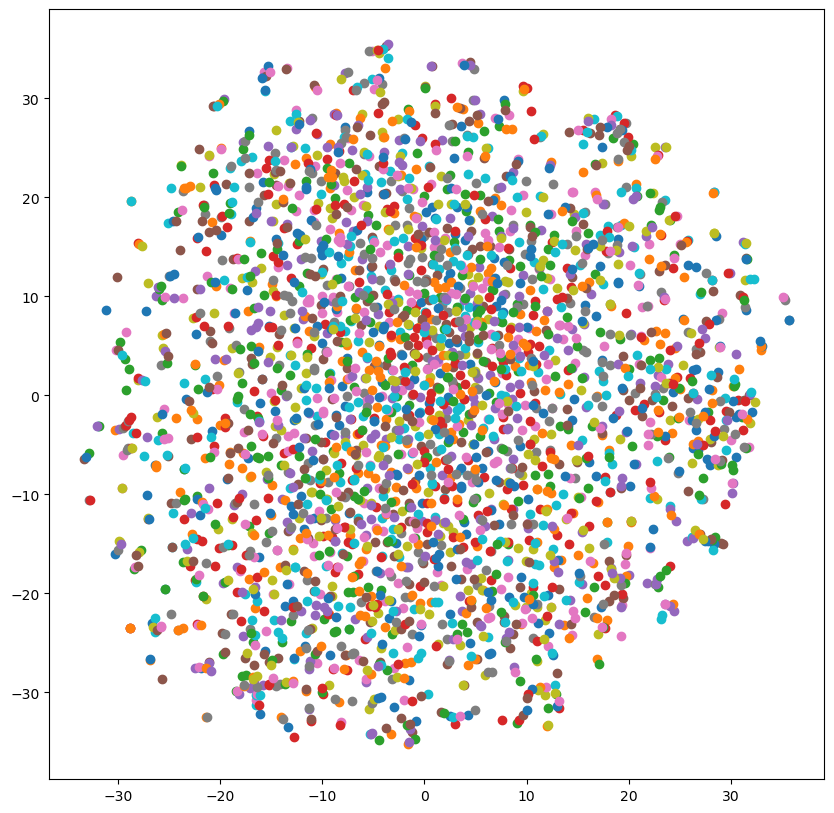

In [7]:
vocabulary = list(model_w2v.wv.index_to_key)
# Visualize embeddings
def plot_embeddings(model):
    # Get word vectors for each word in vocabulary
    X = model.wv[model.wv.index_to_key]
    
    # Use t-SNE to reduce dimensionality of embeddings to 2D
    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(X)
    
    # Plot embeddings
    plt.figure(figsize=(10, 10))
    for i in range(len(vocabulary)):
        plt.scatter(X_tsne[i, 0], X_tsne[i, 1])
    plt.show()

plot_embeddings(model_w2v)

In [8]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [9]:
wordvec_arrays = np.zeros((len(tokenized_selected_text), 100))

for i in range(len(tokenized_selected_text)):
    wordvec_arrays[i,:] = word_vector(tokenized_selected_text[i], 100)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(27481, 100)

##### Model

In [10]:
model_NN = tf.keras.models.Sequential([
    Dense(512, activation='relu', input_shape=(200,)),
    Dense(512, activation='relu'),
    Dense(1, activation='softmax')
])

2023-04-23 13:08:38.468084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 13:08:38.468816: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [11]:
model_NN.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [14]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [16]:
for i in range(0, len(sentiments)):
    if (sentiments[i] == 'negative'):
        sentiments[i] = -1
    elif (sentiments[i] == 'positive'):
        sentiments[i] = 1
    else:
        sentiments[i] = 0

print(sentiments[:4])

[0 -1 -1 -1]


In [20]:
scores = []
X = wordvec_arrays
y = sentiments

unknown_idx = np.where(y == "unknown")[0]
X = np.delete(X, unknown_idx, axis=0)
y = np.delete(y, unknown_idx, axis=0)


for train_idx, test_idx in enumerate(rskf.split(X, y)):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    model_NN.fit(X_train, y_train, epochs=10, batch_size=1064, verbose=0)
    _, score = model_NN.evaluate(X_test, y_test, verbose=0)
    scores.append(score)

print(f"Accuracy scores: {scores}")

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'unknown' instead.